In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [2]:
%matplotlib inline

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
LUNG_CSV = DATA / "C:/Users/Nguyen Loc Phuoc/Desktop/Oreily/2024/Practical Statistics for Data Scientists/LungDisease.csv"
HOUSE_CSV = DATA / "C:/Users/Nguyen Loc Phuoc/Desktop/Oreily/2024/Practical Statistics for Data Scientists/house_sales.csv"

### 1.1 Simple Linear Regression

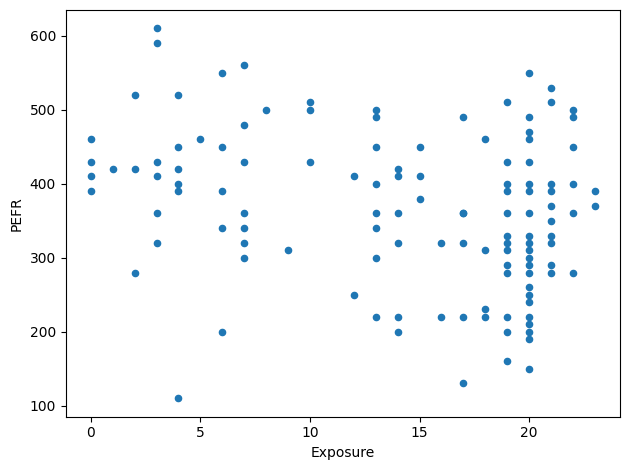

In [5]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [6]:
# We can use the LinearRegression model from scikit-learn.

predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


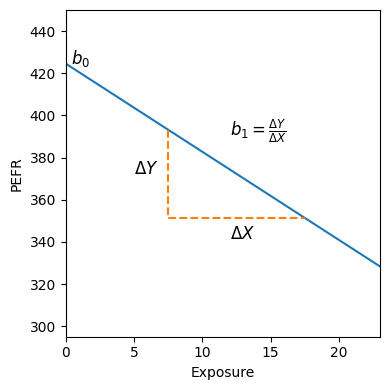

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5,17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

#### Fitted Values and Residuals

In [8]:
#Important concepts in regression analysis are the fitted values (the predictions) and
#residuals (prediction errors). In general, the data doesn’t fall exactly on a line, so the
#regression equation should include an explicit error term e

In [9]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

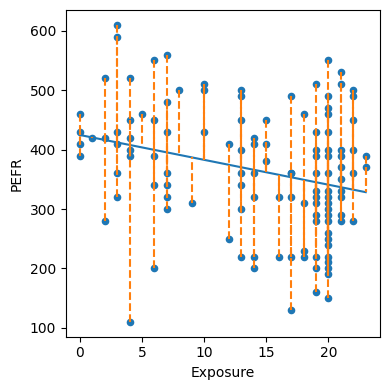

In [10]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

### 1.2 Multi Linear Regression

In [11]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [12]:
# The goal is to predict the sales price from the other variables

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.83060360240756
 SqFtLot: -0.06046682065306186
 Bathrooms: -19442.84039832111
 Bedrooms: -47769.95518521415
 BldgGrade: 106106.96307898115


In [13]:
# For example, adding an extra finished square foot (1m2) to a house increases the estimated value by roughly $229; 
# adding 1,000 finished  square feet (1000 m2) implies the value will increase by $228,800

#### Assessing the Model

In [14]:
#The most important performance metric from a data science perspective is root mean squared error, or RMSE. 

In [15]:
# Scikit-learn provides a number of metrics to determine the quality of a model. Here we use the r2_score.

fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


In [16]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:27:05   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

#### Model Selection and Stepwise Regression

In [17]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True, dtype=int)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:27:05   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

In [18]:
# We can use the stepwise_selection method from the dmba package.

y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade


Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420169
 BldgGrade: 137159.56022619663
 YrBuilt: -3565.424939249451
 Bedrooms: -51947.38367361402
 Bathrooms: 42396.16452772084
 PropertyType_Townhouse: 84479.16203300131
 SqFtFinBasement: 7.046974967551216
 PropertyType_Single Family: 22912.055187017668


#### Weighted Regression

In [19]:
# We can calculate the Year from the date column using either a list comprehension or the data frame's apply method.
# compute a Weight as the number of years since 2005 (the beginning of the data)

house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [20]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


In [21]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
# axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
# axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


### 1.3 Prediction Using Regression

In [22]:
# Mục đích chính của hồi quy trong khoa học dữ liệu là dự đoán. Điều này rất hữu ích cần ghi nhớ, vì hồi quy, 
# là một phương pháp thống kê cũ và đã được thiết lập, 
# đi kèm với hành trang phù hợp hơn với vai trò truyền thống của nó như một công cụ để mô hình hóa giải thích hơn là dự đoán.

### 1.4 Factor variables in regression

#### Dummy Variables Representation

In [23]:
print(house.PropertyType.head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [24]:
print(pd.get_dummies(house['PropertyType']).head(6))
# By default, returns one hot encoding of the categorical variable.

   Multiplex  Single Family  Townhouse
1       True          False      False
2      False           True      False
3      False           True      False
4      False           True      False
5      False           True      False
6      False          False       True


In [25]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))
# The keyword argument drop_first will return P – 1 columns. Use this to avoid the problem of multicollinearity


   Single Family  Townhouse
1          False      False
2           True      False
3           True      False
4           True      False
5           True      False
6          False       True


In [26]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503802
 SqFtLot: -0.07036798136813438
 Bathrooms: -15979.013473415285
 Bedrooms: -50889.732184830005
 BldgGrade: 109416.305161462
 PropertyType_Single Family: -84678.21629549272
 PropertyType_Townhouse: -115121.97921609186


In [27]:
# . The coefficients are interpreted as relative
# to Multiplex, so a home that is Single Family is worth almost $85,000 less, 
# and a home that is Townhouse is worth over $115,000 less.

#### Factor Variables with Many Levels

In [28]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

ZipCode  98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
count      788    671    641    620    619    614    575    517    513    502   

ZipCode  ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
count    ...     32     31      9      7      4      4      3      1      1   

ZipCode  98043  
count        1  

[1 rows x 80 columns]


In [29]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

ZipGroup
0    16
1    16
2    16
3    16
4    16
Name: count, dtype: int64


In [30]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

In [31]:
house.head(5)

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,ZipGroup
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,6,7,1991,0,0,70000,229000,98002,False,2
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,4,10,2005,0,0,203000,590000,98166,True,2
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,4,8,1947,0,0,183000,275000,98166,False,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,5,7,1966,0,0,104000,229000,98168,False,2
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,4,7,1948,0,0,104000,205000,98168,False,2


### 1.4 Interpreting the Regression Equation

#### Correlated predictors

In [32]:
# The results from the stepwise regression are.

print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420169
 BldgGrade: 137159.56022619663
 YrBuilt: -3565.424939249451
 Bedrooms: -51947.38367361402
 Bathrooms: 42396.16452772084
 PropertyType_Townhouse: 84479.16203300131
 SqFtFinBasement: 7.046974967551216
 PropertyType_Single Family: 22912.055187017668


In [33]:
# The coefficient for Bedrooms is negative! This implies that adding a bedroom to a
# house will reduce its value. How can this be? This is because the predictor variables
# are correlated: larger houses tend to have more bedrooms, and it is the size that drives
# house value, not the number of bedrooms. Consider two homes of the exact same
# size: it is reasonable to expect that a home with more but smaller bedrooms would be
# considered less desirable

In [34]:
# To make "Bedrooms" not negative anymore
# We need to refit the model with the modified predictor list:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.53723021974
 BldgGrade: 248997.79366212635
 YrBuilt: -3211.744862155111
 PropertyType_Single Family: -19898.49534050197
 PropertyType_Townhouse: -47355.43687334427


#### Confounding variables

In [35]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.6126600558012
 SqFtLot: 0.454987138546608
 Bathrooms: 5928.425640001448
 Bedrooms: -41682.871840744505
 BldgGrade: 98541.18352725997
 PropertyType_Single Family: 19323.625287919775
 PropertyType_Townhouse: -78198.72092762342
 ZipGroup_1: 53317.17330659808
 ZipGroup_2: 116251.58883563541
 ZipGroup_3: 178360.53178793358
 ZipGroup_4: 338408.6018565204


In [36]:
#ZipGroup is clearly an important variable: a home in the most expensive zip code
#group is estimated to have a higher sales price by almost $340,000. The coefficients of
#SqFtLot and Bathrooms are now positive, and adding a bathroom increases the sale
#price by $5,928.

#The coefficient for Bedrooms is still negative. 
#While this is unintuitive, this is a wellknown phenomenon in real estate. For homes of the same livable area and number of
#bathrooms, having more and therefore smaller bedrooms is associated with less valuable homes.

#### Interactions and Main Effects

In [37]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:27:08   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [38]:
# For a home in the highest ZipGroup,
# the slope is the sum of the main effect plus SqFtTotLiving:ZipGroup5, or $115 +$227 = $342 per square foot. 
# In other words, adding a square foot in the most expensive zip code group boosts the predicted sale price by a factor of almost three, 
# compared to the average boost from adding a square foot.

In [39]:
#Notes:
#[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
#[2] The condition number is large, 5.8e+05. This might indicate that there are strong multicollinearity or other numerical problems.

### 1.5 Testing the Assumptions: Regression Diagnostics

#### Outliers

In [40]:
# Let’s fit a regression to the King County house sales data for all sales in zip code 98105
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Fri, 12 Jan 2024   Prob (F-statistic):          1.69e-103
Time:                        09:47:43   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

In [41]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.3267318040785625


In [42]:
print(result_98105.resid.loc[sresiduals.idxmin()])


-757753.6192115827


In [45]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


#### Influential Value 

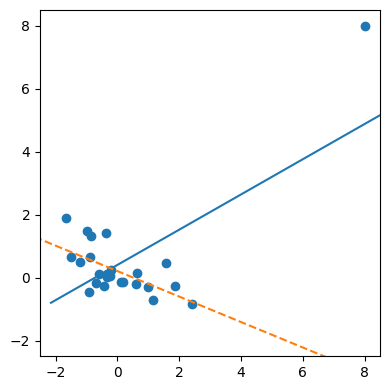

In [50]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)

# outlite value
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

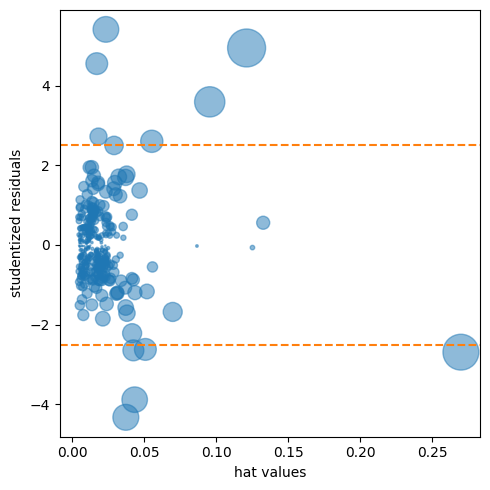

In [51]:
# An influence plot or bubble plot combines standardized residuals, the hat-value, and Cook’s distance in a single plot.
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

### Heteroskedasticity, Non-Normality, and Correlated Errors

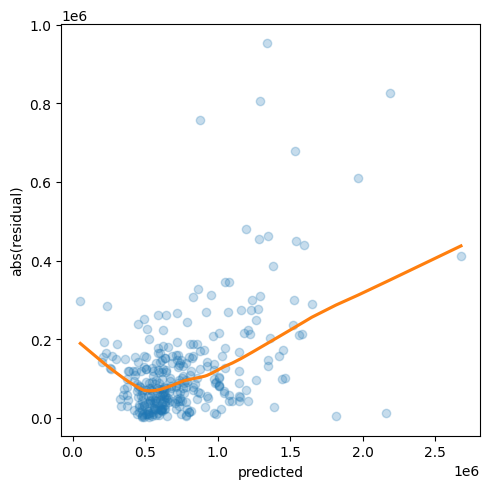

In [52]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

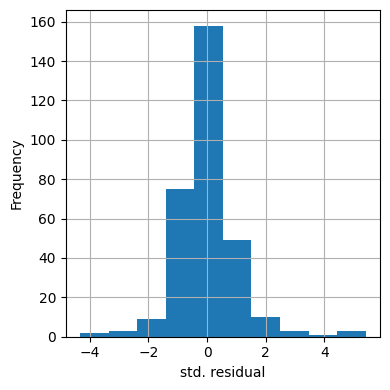

In [53]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()
